### Clustering

---


### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold  #needed for and t-SNE
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import cluster  #needed for k-Means clustering
from sklearn import metrics  #needed for Silhouette method
from sklearn import preprocessing  #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [2]:
df = pd.read_csv("./tracks.csv")
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1495,23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,opera
1496,22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,opera
1497,23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,opera
1498,23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,opera
1499,23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,opera


In [3]:
df.isna().sum()

popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

# Parameter tuning

Genre is dropped, as it is categorical data.

Explicit is mapped to 0 and 1, to replace the bool, as well as to be more consistent with other features being in the range of 0-1

Popularity is changed to a boolean value of 0 and 1, with songs ranked over 50 being considered popular. This produced better results for clustering and a more definitive silhouette coefficient.

In [4]:
df.drop(columns=["track_genre"], inplace=True, errors='ignore')

bool_mapper = {
    False: 0,
    True: 1,
}
df['popularity'] = df['popularity'].apply(lambda x: 1 if x > 50 else 0)
df['explicit'] = df['explicit'].replace(bool_mapper)
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4


Here we created the `preprocess_pipeline` in order to make sure that the features of this dataset were appropriately scaled and transformed before being fed into the clustering model.

In [5]:
y = df['popularity']
X = df.drop('popularity', axis=1)

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# outliers
# - duration
# - loudness
# - speechiness
# - instrumentalness
# - liveness
# - tempo


columns_outliers_no_skew = ["speechiness", "instrumentalness", "liveness"]

columns_outliers_skewed = ['duration_ms', 'loudness', 'tempo']

columns_no_outliers_skewed = ["duration_ms",
                              "danceability",
                              "energy",
                              "loudness",
                              "speechiness",
                              "acousticness",
                              "instrumentalness",
                              "liveness",
                              "valence",
                              "tempo",
                              ]

columns_no_outliers_no_skew = [col for col in X.columns if
                               col not in columns_outliers_no_skew and col not in columns_no_outliers_skewed and col not in columns_outliers_skewed]

outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
        ("scaler", preprocessing.RobustScaler())
    ]
)

outliers_skewed_pipeline = Pipeline(steps=[
    ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
    ('scale', preprocessing.RobustScaler())
])

no_outliers_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", preprocessing.PowerTransformer(method="yeo-johnson")),
        ("scaler", preprocessing.MinMaxScaler())
    ]
)

no_outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("scaler", preprocessing.MinMaxScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("outliers_skewed", outliers_skewed_pipeline, columns_outliers_skewed),
        ("outliers_not_skewed", outliers_no_skew_pipeline, columns_outliers_no_skew),
        ("no_outliers_skewed", no_outliers_skewed_pipeline, columns_no_outliers_skewed),
        ("no_outliers_no_skew", no_outliers_no_skew_pipeline, columns_no_outliers_no_skew)
    ],
    remainder="passthrough"
)

- Firsly, for features with strong outliers and no skew, we applied a Yeo-Johnson transform followed by scaling with the RobustScaler.
- Then, for highly skewed features with significant outliers, we applied a Yeo-Johnson power transformation followed by robust scaling to mitigate the impact of extreme values.
- Then for moderately skewed features without strong outliers, we applied a Yeo-Johnson transform followed by MinMax scaling.
- And lastly, features without noticeable skew or outliers were scaled directly using a MinMax scaler.

**Note**: We chose the Yeo-Johnson transformation over a log transformation because it can handle both positive and negative values, including zeros, without requiring manual data shifts, providing a more flexible and robust normalization method. (reference [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html))



In [7]:
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (1500, 15)


---

### Scatterplot




In [8]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])


# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels == i, 0],
                        points[labels == i, 1],
                        c=colors[i % colors.size],
                        label='cluster ' + str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

---
### K-Means Clustering (Roy)

Number of clusters $k$.

For determining the ideal value of K, the elbow-method was used, mapping the sum of squares of the clusters to the graph. When the decline starts to flatten, like a bent elbow, that is the ideal value of k.

Through this, k=3 was the ideal value of k

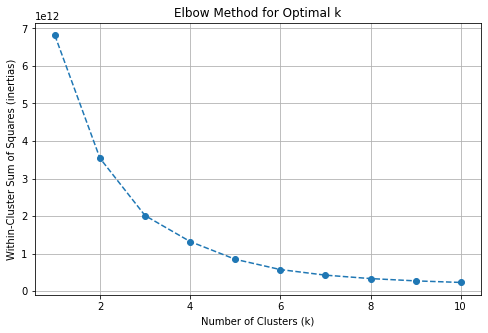

In [9]:
inertias = []  # the sum of squared distances
k_values = range(1, 11)

for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (inertias)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [10]:
k = 3

#### Run k-Means

This creates a pipeline that runs the preprocessing pipeline, and then kmeans

In [11]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

kmeans_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),  # dimensionality reduction
    ('kMeans', cluster.KMeans(n_init=10, n_clusters=k, max_iter=300))
])

param_grid = {
    'kMeans__n_clusters': [3, 4, 5, 8, 10],  # want at least 3 as per elbow method
    'kMeans__n_init': [1, 2, 3, 4, 5, 10],

    'pca__n_components': [None, 5, 10, 15],  # None = keep all attributes
    'pca__whiten': [False, True],
}


def silhouette_scorer(estimator, X, y=None):
    # pipelines generally used for supervised learning, but clustering is unsupervised
    # this method allows us to use silhouette score as our sort of supervision
    # to do this, we follow same steps as pipeline, then cluster using the given config
    # and use silhouette score to evaluate it
    # using this in grid search will allow it to pick best params for clustering
    transformed = estimator.named_steps['preprocess'].transform(X)
    pca_done = estimator.named_steps['pca'].transform(transformed)
    labels = estimator.named_steps['kMeans'].predict(pca_done)
    # If we got only one cluster, silhouette is undefined
    if len(np.unique(labels)) < 2:
        return -1.0
    return silhouette_score(pca_done, labels)


grid_search = GridSearchCV(
    estimator=kmeans_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(df)

print("Best params:", grid_search.best_params_)
print("Best silhouette score:", grid_search.best_score_)
best_pipeline = grid_search.best_estimator_

clustered_model = best_pipeline
preprocessed_data = clustered_model["preprocess"].transform(df)
preprocessed_data = clustered_model["pca"].transform(preprocessed_data)
preprocessed_data

Best params: {'kMeans__n_clusters': 3, 'kMeans__n_init': 1, 'pca__n_components': 5, 'pca__whiten': False}
Best silhouette score: 0.2479349924177337


array([[ 0.36315303, -0.34985339,  0.8208697 , -0.36610747, -0.08906604],
       [ 0.52737664, -0.27282678,  0.60266913, -0.80950881, -0.34196655],
       [ 0.24411565,  1.33881464, -1.11809807,  0.51891598,  0.08034597],
       ...,
       [ 1.24730588, -0.59510777,  1.24199102, -0.23732374,  0.03613835],
       [ 0.46441114,  0.31865434,  1.86088808,  0.89815031,  0.93334392],
       [ 2.53735184,  0.49227063,  0.14892872, -0.12045053, -0.82941818]])

Note here how value of k found to be best differs from that of elbow method

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the dataset.

In [12]:
data_and_centers = np.r_[preprocessed_data, clustered_model['kMeans'].cluster_centers_]

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

In [13]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

transformation complete


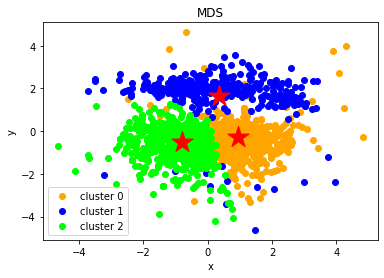

In [14]:
clustering_scatterplot(points=XYcoordinates[:-k, :],
                       labels=clustered_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:, :],
                       title='MDS')

TODO conclusions from MDS clustering

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [15]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


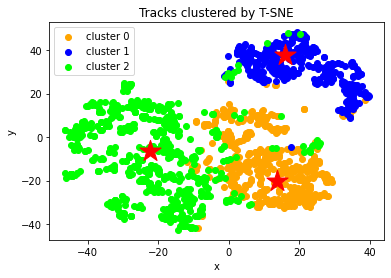

In [16]:
clustering_scatterplot(points=XYcoordinates[:-k, :],
                       labels=clustered_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:, :],
                       title='Tracks clustered by T-SNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [17]:
df['cluster'] = pd.Series(clustered_model['kMeans'].labels_, index=df.index)

In [18]:
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
1495,0,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,0
1496,0,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,0
1497,0,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,0
1498,0,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,0
1499,0,257800,0,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,1


#### Compute the mean value of each attribute for each cluster

In [19]:
df.groupby('cluster').mean()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,,
0,0.164179,243881.379531,0.023454,0.399129,0.400342,4.912580,-10.862842,0.763326,0.042217,0.645876,0.015774,0.193666,0.264003,106.786011,3.739872
1,0.173295,206738.750000,0.048295,0.497845,0.589144,4.613636,-10.493287,0.724432,0.063143,0.366969,0.680752,0.187990,0.251695,115.005193,3.857955
2,0.225331,187728.976436,0.189985,0.661517,0.731116,5.356406,-5.419361,0.541973,0.109262,0.132262,0.004243,0.199218,0.523428,124.922353,3.988218


Each cluster falls under the following trends:


One cluster are more popular tracks.

One cluster are tracks that are louder, more energetic and danceable,

One cluster is quieter, acoustic, lower-tempo, lower-energy tracks.

As evident from the scatter-plots, the cluster with acoustic, lower-energy tracks is the smallest, while the other two are equal in size.

# Clustering with DBScan

DBSCAN Pipeline

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Define Clustering Pipeline
clustering_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('dbscan', DBSCAN())
])

# Grid Search Param Grid
param_grid = {
    'dbscan__eps': [0.3, 0.5, 0.7, 1.0],
    'dbscan__min_samples': [3, 5, 10],
}

# Custom silhouette scorer
def silhouette_scorer(estimator, X, y=None):
    transformed = estimator.named_steps['preprocess'].transform(X)
    labels = estimator.named_steps['dbscan'].fit_predict(transformed)
    
    if len(np.unique(labels)) <= 1 or (len(np.unique(labels)) == 2 and -1 in np.unique(labels)):
        return -1.0
    return silhouette_score(transformed, labels)

# Grid Search
grid_search = GridSearchCV(
    estimator=clustering_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=silhouette_scorer,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(df)

# Best model
best_cluster_pipeline = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)


Best parameters: {'dbscan__eps': 1.0, 'dbscan__min_samples': 3}


## Visualisation Pipeline TSNE

In [29]:
from sklearn.manifold import TSNE

# Visualization pipeline
visualization_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),  # Same preprocessing!
    ('tsne', TSNE(n_components=3, random_state=42))
])

# Run visualization
tsne_data = visualization_pipeline.fit_transform(df)

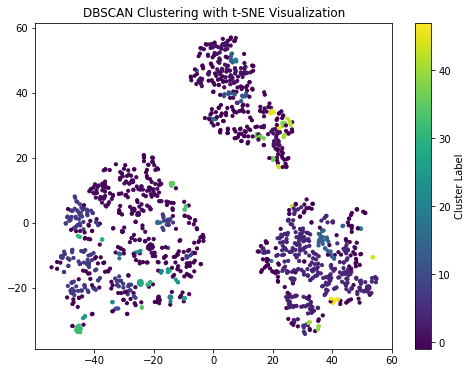

In [26]:
# Predict cluster labels
preprocessed_data = best_cluster_pipeline["preprocess"].transform(df)
labels = best_cluster_pipeline["dbscan"].fit_predict(preprocessed_data)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='viridis', s=10)
plt.title("DBSCAN Clustering with t-SNE Visualization")
plt.colorbar(label='Cluster Label')
plt.show()

# MDS

/Users/adamgreenan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


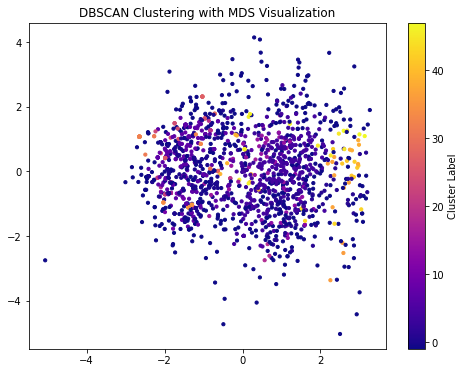

In [28]:
from sklearn.manifold import MDS

mds_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('mds', MDS(n_components=3, random_state=42))
])

mds_data = mds_pipeline.fit_transform(df)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, cmap='plasma', s=10)
plt.title("DBSCAN Clustering with MDS Visualization")
plt.colorbar(label='Cluster Label')
plt.show()

## DB Scan Conclusion

MDS' visualisation is clearly sparse and spread out. No distinct clustering forming and overall poor.

t-SNE on the other hand provides clear clustering with DBScan. Showing clear clumping of data points, compared to MDS' sparse visualisation.

Overall, t-SNE provides a clearer and more interpretable visualization of the DBSCAN clustering results in this case. MDS tends to blur the local structures, while t-SNE highlights them sharply, making it the better choice for visualizing complex, non-linear cluster shapes in high-dimensional data.

# Conclusion

k-means clustering assumes that clusters are spherical and equally sized. It performed well in forming clear, compact clusters when the number of clusters (k) was appropriately chosen. However, it required setting k manually in advance, and its performance degraded if the true clusters were not globular or were very differently sized.

DBSCAN does not need you to set the number of clusters beforehand. It can find clusters of any shape and also detect noise points (outliers). It worked well for irregular clusters but is sensitive to the eps (distance) and min_samples (density) settings, which can affect the results a lot.